In [1]:
from pathlib import Path
import polars as pl 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import altair as alt
import yaml
from datetime import date
import numpy as np
from varname import nameof

In [2]:
with open('../config/cfg.yaml') as f:
    config = yaml.safe_load(f)

features = config['features']
target   = config["target"][0]
print(features)

['period_begin', 'period_end', 'region', 'state_code', 'median_sale_price', 'median_list_price', 'median_ppsf', 'homes_sold', 'inventory', 'new_listings', 'months_of_supply', 'median_dom', 'pending_sales', 'avg_sale_to_list', 'sold_above_list', 'price_drops', 'off_market_in_two_weeks', 'median_sale_price_mom', 'median_sale_price_yoy', 'months_of_supply_mom', 'months_of_supply_yoy', 'homes_sold_mom', 'homes_sold_yoy', 'inventory_mom', 'inventory_yoy', 'median_dom_mom', 'median_dom_yoy', 'price_drops_mom', 'price_drops_yoy', 'pending_sales_mom', 'pending_sales_yoy', 'new_listings_mom', 'new_listings_yoy', 'property_type']


In [3]:
DATA_PATH         = Path("../data")
COUNTY_PATH       = DATA_PATH / "county_market_tracker.tsv000"
NEIGHBORHOOD_PATH = DATA_PATH / "neighborhood_market_tracker.tsv000"
STATE_PATH        = DATA_PATH / "state_market_tracker.tsv000"
US_NATION_PATH    = DATA_PATH / "us_national_market_tracker.tsv000"
ZIP_PATH          = DATA_PATH / "zip_code_market_tracker.tsv000"

In [5]:
county_df = pl.read_csv(COUNTY_PATH, separator="\t", columns=features).with_columns(
    pl.col("period_begin").cast(pl.Date()),
    pl.col("period_end").cast(pl.Date())
)
county_df.glimpse()

Rows: 563122
Columns: 34
$ period_begin            <date> 2017-04-01, 2014-12-01, 2018-02-01, 2017-08-01, 2019-05-01, 2017-06-01, 2019-12-01, 2018-06-01, 2018-07-01, 2014-11-01
$ period_end              <date> 2017-04-30, 2014-12-31, 2018-02-28, 2017-08-31, 2019-05-31, 2017-06-30, 2019-12-31, 2018-06-30, 2018-07-31, 2014-11-30
$ region                   <str> 'Morgan County, AL', 'Hennepin County, MN', 'Tulsa County, OK', 'Crow Wing County, MN', 'Tate County, MS', 'Walworth County, WI', 'Madison County, AL', 'Hamilton County, TX', 'Idaho County, ID', 'Guilford County, NC'
$ state_code               <str> 'AL', 'MN', 'OK', 'MN', 'MS', 'WI', 'AL', 'TX', 'ID', 'NC'
$ property_type            <str> 'All Residential', 'Multi-Family (2-4 Unit)', 'All Residential', 'Condo/Co-op', 'Single Family Residential', 'Single Family Residential', 'Multi-Family (2-4 Unit)', 'Single Family Residential', 'Single Family Residential', 'Condo/Co-op'
$ median_sale_price        <f64> 120500.0, 203000.0, 167500

In [6]:
county_df.null_count()

period_begin,period_end,region,state_code,property_type,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_ppsf,homes_sold,homes_sold_mom,homes_sold_yoy,pending_sales,pending_sales_mom,pending_sales_yoy,new_listings,new_listings_mom,new_listings_yoy,inventory,inventory_mom,inventory_yoy,months_of_supply,months_of_supply_mom,months_of_supply_yoy,median_dom,median_dom_mom,median_dom_yoy,avg_sale_to_list,sold_above_list,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,685,52383,69332,43920,7395,679,52377,69325,79883,125130,142945,44898,82938,99747,22906,66101,84719,14964,58355,76113,8797,60417,77922,7931,5520,237761,264795,300991,66963


In [7]:
county_df.describe()

statistic,period_begin,period_end,region,state_code,property_type,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_ppsf,homes_sold,homes_sold_mom,homes_sold_yoy,pending_sales,pending_sales_mom,pending_sales_yoy,new_listings,new_listings_mom,new_listings_yoy,inventory,inventory_mom,inventory_yoy,months_of_supply,months_of_supply_mom,months_of_supply_yoy,median_dom,median_dom_mom,median_dom_yoy,avg_sale_to_list,sold_above_list,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks
str,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""563122""","""563122""","""563122""","""563122""","""563122""",562437.0,510739.0,493790.0,519202.0,555727.0,562443.0,510745.0,493797.0,483239.0,437992.0,420177.0,518224.0,480184.0,463375.0,540216.0,497021.0,478403.0,548158.0,504767.0,487009.0,554325.0,502705.0,485200.0,555191.0,557602.0,325361.0,298327.0,262131.0,496159.0
"""null_count""","""0""","""0""","""0""","""0""","""0""",685.0,52383.0,69332.0,43920.0,7395.0,679.0,52377.0,69325.0,79883.0,125130.0,142945.0,44898.0,82938.0,99747.0,22906.0,66101.0,84719.0,14964.0,58355.0,76113.0,8797.0,60417.0,77922.0,7931.0,5520.0,237761.0,264795.0,300991.0,66963.0
"""mean""","""2017-03-14 16:01:17.073174""","""2017-04-13 02:47:53.468981""",null,null,null,204856.654317,1.167698,1.935374,232030.213737,1928.200556,121.35341,0.150434,0.347846,108.167373,0.167598,0.436182,154.916991,0.172941,0.259994,421.794199,0.009573,0.16447,5.701756,-0.138046,-0.988874,109.74947,-1.091533,-12.360146,0.959902,0.172628,0.200533,0.001515,0.004358,0.258053
"""std""",null,null,null,null,null,1.5061e6,388.591865,512.005735,1.9693e6,1.3414e6,347.492394,1.050092,3.983469,320.6543,1.254917,3.996148,430.174966,9.081662,7.013485,1118.946608,1.598657,8.601857,6.403006,7.539451,10.444344,195.650664,190.736681,202.129677,0.052256,0.192663,0.12395,0.092652,0.103921,0.249914
"""min""","""2012-01-01""","""2012-01-31""","""Abbeville County, SC""","""AK""","""All Residential""",1.0,-0.999996,-0.999994,100.0,0.00036,1.0,-0.972603,-0.988889,1.0,-0.9875,-0.982143,1.0,-0.995543,-0.994444,1.0,-0.959459,-0.992453,0.0,-1548.4,-1550.2,1.0,-8754.0,-15618.0,0.5,0.0,0.000058,-0.916667,-0.990566,0.0
"""25%""","""2014-10-01""","""2014-10-31""",null,null,null,115000.0,-0.096043,-0.043404,139900.0,71.743697,4.0,-0.195238,-0.117647,4.0,-0.2,-0.090909,7.0,-0.214286,-0.148148,21.0,-0.074286,-0.228049,2.5,-1.0,-2.0,41.0,-18.0,-32.0,0.942682,0.0,0.125926,-0.036976,-0.038988,0.0
"""50%""","""2017-05-01""","""2017-05-31""",null,null,null,163750.0,0.006536,0.075832,189900.0,99.027947,18.0,0.0,0.046218,15.0,0.0,0.105263,27.0,0.0,0.017544,85.0,-0.002326,-0.073892,4.2,0.0,-0.6,72.0,0.0,-7.0,0.968054,0.134021,0.183386,0.001292,0.001951,0.217391
"""75%""","""2019-09-01""","""2019-09-30""",null,null,null,238500.0,0.121857,0.221212,269950.0,136.258661,80.0,0.25,0.333333,68.0,0.285714,0.481481,110.0,0.269697,0.262295,331.0,0.055556,0.086849,7.0,0.9,0.5,120.0,16.0,12.0,0.986673,0.25,0.25,0.038642,0.043651,0.415385
"""max""","""2021-12-01""","""2021-12-31""","""Zavala County, TX""","""WV""","""Townhouse""",9.99999999e8,189999.0,220999.0,9.99999998e8,9.99999999e8,9186.0,250.0,696.0,8218.0,282.5,973.0,9899.0,4222.0,4222.0,26655.0,539.0,976.0,874.0,543.5,862.0,15811.0,15749.0,15774.0,1.963048,1.0,1.0,0.923077,0.954545,1.5


In [8]:
county_df.head()

period_begin,period_end,region,state_code,property_type,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_ppsf,homes_sold,homes_sold_mom,homes_sold_yoy,pending_sales,pending_sales_mom,pending_sales_yoy,new_listings,new_listings_mom,new_listings_yoy,inventory,inventory_mom,inventory_yoy,months_of_supply,months_of_supply_mom,months_of_supply_yoy,median_dom,median_dom_mom,median_dom_yoy,avg_sale_to_list,sold_above_list,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks
date,date,str,str,str,f64,f64,f64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,f64,f64,f64,i64,i64,i64,f64,f64,f64,f64,f64,f64
2017-04-01,2017-04-30,"""Morgan County, AL""","""AL""","""All Residential""",120500.0,-0.076628,-0.107077,147900.0,75.845434,106,-0.109244,-0.131148,48,0.0,-0.058824,140,0.196581,0.076923,439,0.068127,-0.142578,4.1,0.6,-0.1,101,-28,-10,0.960914,0.09434,null,null,null,0.020833
2014-12-01,2014-12-31,"""Hennepin County, MN""","""MN""","""Multi-Family (2-4 Unit)""",203000.0,-0.171429,0.052632,210000.0,86.633333,57,0.628571,-0.109375,29,0.0,-0.147059,21,-0.5625,-0.447368,133,-0.231214,-0.043165,2.3,-2.6,0.1,76,31,17,0.977672,0.245614,0.097744,-0.121909,-0.19722,0.172414
2018-02-01,2018-02-28,"""Tulsa County, OK""","""OK""","""All Residential""",167500.0,0.021341,0.101974,179700.0,89.76558,665,0.136752,0.084829,523,0.050201,-0.095156,941,0.08912,0.012917,2665,0.012538,0.002256,4.0,-0.5,-0.3,69,15,15,0.973126,0.177444,0.206004,-0.026139,0.009313,0.479924
2017-08-01,2017-08-31,"""Crow Wing County, MN""","""MN""","""Condo/Co-op""",125000.0,-0.137931,null,209900.0,147.076613,3,2.0,null,null,null,null,3,null,null,5,0.25,null,1.7,-2.3,null,107,-5,null,0.964538,0.0,0.2,-0.05,null,null
2019-05-01,2019-05-31,"""Tate County, MS""","""MS""","""Single Family Residential""",165000.0,-0.144635,-0.046243,181444.0,85.0,19,0.0,-0.05,6,-0.333333,-0.4,18,-0.181818,-0.142857,80,-0.036145,-0.02439,4.2,-0.2,0.1,117,17,-36,0.981283,0.157895,null,null,null,0.0


In [9]:
county_df = county_df.fill_null(strategy="mean")
county_df.null_count()

period_begin,period_end,region,state_code,property_type,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_ppsf,homes_sold,homes_sold_mom,homes_sold_yoy,pending_sales,pending_sales_mom,pending_sales_yoy,new_listings,new_listings_mom,new_listings_yoy,inventory,inventory_mom,inventory_yoy,months_of_supply,months_of_supply_mom,months_of_supply_yoy,median_dom,median_dom_mom,median_dom_yoy,avg_sale_to_list,sold_above_list,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
county_df.sort("period_begin").group_by("period_begin").agg(pl.col("median_sale_price").mean()).plot.line(
    x="period_begin",
    y="median_sale_price"
).properties(
    width=700,
    height=500
).interactive()

alt.Chart(...)

In [11]:
county_df.filter(
    pl.col("period_begin").dt.year() == 2020
).sort("period_begin").group_by(pl.col("period_begin")).agg(pl.col(target).mean()).sort(target, descending=True)

period_begin,median_sale_price
date,f64
2020-08-01,443955.725739
2020-09-01,353603.636927
2020-10-01,260976.136142
2020-12-01,258914.736523
2020-11-01,257434.639791
…,…
2020-06-01,237098.737916
2020-05-01,236320.307852
2020-03-01,235490.922101


In [12]:
county_df.filter(
    pl.col("period_begin") == date(2020, 8, 1)
).sort(target, descending=True).head()

period_begin,period_end,region,state_code,property_type,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_ppsf,homes_sold,homes_sold_mom,homes_sold_yoy,pending_sales,pending_sales_mom,pending_sales_yoy,new_listings,new_listings_mom,new_listings_yoy,inventory,inventory_mom,inventory_yoy,months_of_supply,months_of_supply_mom,months_of_supply_yoy,median_dom,median_dom_mom,median_dom_yoy,avg_sale_to_list,sold_above_list,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks
date,date,str,str,str,f64,f64,f64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,f64,f64,f64,i64,i64,i64,f64,f64,f64,f64,f64,f64
2020-08-01,2020-08-31,"""Union County, OH""","""OH""","""Multi-Family (2-4 Unit)""",9.99999999e8,1.167698,2208.944749,232030.213737,9.99999999e8,1,0.150434,0.0,108,0.167598,0.436182,154,0.172941,0.259994,421,0.009573,0.16447,5.701756,-0.138046,-0.988874,109,-1,-12,1.0,0.0,0.200533,0.001515,0.004358,0.258053
2020-08-01,2020-08-31,"""New York County, NY""","""NY""","""Townhouse""",5.5e6,1.167698,1.935374,1.175e6,1003.649635,1,0.150434,0.347846,108,0.167598,0.436182,1,0.172941,0.259994,15,0.009573,0.16447,15.0,-0.138046,-0.988874,178,-1,-12,1.0,0.0,0.133333,0.001515,0.004358,0.258053
2020-08-01,2020-08-31,"""Nantucket County, MA""","""MA""","""All Residential""",3.425e6,-0.03146,1.446429,2.695e6,914.504717,4,-0.5,-0.333333,15,0.666667,1.5,16,-0.238095,1.0,47,-0.078431,-0.145455,11.8,5.4,2.6,73,-46,-17,0.971717,0.25,0.170213,-0.006258,-0.102515,0.066667
2020-08-01,2020-08-31,"""Nantucket County, MA""","""MA""","""Single Family Residential""",3.425e6,-0.03146,1.446429,2.695e6,914.504717,4,-0.5,-0.333333,15,1.5,1.5,16,-0.157895,1.0,46,-0.061224,-0.098039,11.5,5.4,3.0,73,-46,-17,0.971717,0.25,0.152174,0.009317,-0.102728,0.066667
2020-08-01,2020-08-31,"""New York County, NY""","""NY""","""Single Family Residential""",3.25e6,-0.811594,-0.044118,1.175e6,938.009788,4,0.0,0.0,1,0.167598,-0.5,19,-0.095238,0.461538,102,0.120879,0.030303,25.5,2.7,0.7,338,-424,111,1.0,0.0,0.392157,0.01853,0.260844,1.0


- Very large outlier in ohio

In [13]:
Q1 = county_df[target].quantile(0.25)
Q3 = county_df[target].quantile(0.75)
IQR = Q3 - Q1
print(Q1, Q3, IQR)
outliers = county_df.filter(
    (pl.col(target) < np.abs(Q1 - 1.5*IQR)) |
    (pl.col(target) > np.abs(Q3 + 1.5*IQR))
)
outliers.sort(target, descending=True)

115000.0 238250.0 123250.0


period_begin,period_end,region,state_code,property_type,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_ppsf,homes_sold,homes_sold_mom,homes_sold_yoy,pending_sales,pending_sales_mom,pending_sales_yoy,new_listings,new_listings_mom,new_listings_yoy,inventory,inventory_mom,inventory_yoy,months_of_supply,months_of_supply_mom,months_of_supply_yoy,median_dom,median_dom_mom,median_dom_yoy,avg_sale_to_list,sold_above_list,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks
date,date,str,str,str,f64,f64,f64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,f64,f64,f64,i64,i64,i64,f64,f64,f64,f64,f64,f64
2020-08-01,2020-08-31,"""Union County, OH""","""OH""","""Multi-Family (2-4 Unit)""",9.99999999e8,1.167698,2208.944749,232030.213737,9.99999999e8,1,0.150434,0.0,108,0.167598,0.436182,154,0.172941,0.259994,421,0.009573,0.16447,5.701756,-0.138046,-0.988874,109,-1,-12,1.0,0.0,0.200533,0.001515,0.004358,0.258053
2020-09-01,2020-09-30,"""Fayette County, OH""","""OH""","""Condo/Co-op""",5.0010e8,1.167698,1.935374,152200.0,40557.783138,2,0.150434,0.347846,1,0.167598,0.436182,1,0.172941,0.259994,1,0.009573,0.16447,0.5,-0.138046,-0.988874,1,-1,-12,1.0,0.0,1.0,0.001515,0.004358,1.0
2017-11-01,2017-11-30,"""New York County, NY""","""NY""","""Townhouse""",2.6375e7,1.167698,10.722222,232030.213737,1608.981965,2,0.150434,1.0,1,0.167598,0.436182,154,0.172941,0.259994,35,0.009573,-0.375,17.5,-0.138046,-38.5,176,-1,-1456,1.0,0.0,0.114286,0.001515,0.004358,0.0
2017-08-01,2017-08-31,"""New York County, NY""","""NY""","""Townhouse""",2.25e7,2.797468,0.574803,1.225e6,674.157303,2,1.0,0.0,108,0.167598,0.436182,3,0.0,0.5,32,0.032258,-0.567568,16.0,-15.0,-21.0,394,263,323,0.917827,0.0,0.125,-0.294355,0.004358,0.258053
2019-06-01,2019-06-30,"""New York County, NY""","""NY""","""Townhouse""",2.065e7,1.167698,1.56124,1.215e6,2560.714286,4,0.150434,0.0,2,0.167598,0.436182,5,0.172941,1.5,19,0.009573,-0.321429,4.8,-0.138046,-2.2,495,-1,-98,1.0,0.0,0.210526,0.001515,-0.110902,0.5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2017-03-01,2017-03-31,"""Ashtabula County, OH""","""OH""","""Multi-Family (2-4 Unit)""",1.0,-0.999972,-0.999956,89900.0,0.000488,1,-0.5,-0.5,3,2.0,0.0,9,2.0,1.25,26,0.130435,0.083333,26.0,14.5,14.0,97,53,54,0.959902,0.0,0.153846,0.110368,-0.054487,0.0
2012-11-01,2012-11-30,"""Miami County, OH""","""OH""","""Multi-Family (2-4 Unit)""",1.0,-0.999987,-0.999986,110900.0,0.000371,1,-0.75,0.0,2,-0.5,1.0,4,0.0,0.333333,20,0.052632,-0.310345,20.0,15.2,-9.0,175,123,92,0.959902,0.0,0.200533,0.001515,0.004358,0.0
2018-04-01,2018-04-30,"""Andrew County, MO""","""MO""","""Townhouse""",1.0,1.167698,1.935374,232030.213737,0.00036,1,0.150434,0.347846,108,0.167598,0.436182,154,0.172941,0.259994,421,0.009573,0.16447,5.701756,-0.138046,-0.988874,258,-1,-12,0.959902,0.0,0.200533,0.001515,0.004358,0.258053


In [14]:
county_df_clean = county_df.filter(
    (pl.col(target) >= np.abs(Q1 - 1.5*IQR)) &
    (pl.col(target) <= np.abs(Q3 + 1.5*IQR))
)
county_df_clean.sort(target)

period_begin,period_end,region,state_code,property_type,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_ppsf,homes_sold,homes_sold_mom,homes_sold_yoy,pending_sales,pending_sales_mom,pending_sales_yoy,new_listings,new_listings_mom,new_listings_yoy,inventory,inventory_mom,inventory_yoy,months_of_supply,months_of_supply_mom,months_of_supply_yoy,median_dom,median_dom_mom,median_dom_yoy,avg_sale_to_list,sold_above_list,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks
date,date,str,str,str,f64,f64,f64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,f64,f64,f64,i64,i64,i64,f64,f64,f64,f64,f64,f64
2021-12-01,2021-12-31,"""Cleveland County, OK""","""OK""","""Condo/Co-op""",69875.0,-0.240489,-0.177941,225000.0,77.624461,10,-0.090909,0.428571,8,-0.111111,1.666667,5,-0.166667,1.5,5,-0.444444,-0.545455,0.5,-0.3,-1.1,70,13,-11,0.971946,0.2,0.2,0.088889,0.018182,0.5
2014-03-01,2014-03-31,"""Manitowoc County, WI""","""WI""","""Multi-Family (2-4 Unit)""",69875.0,0.193934,-0.001786,99900.0,48.076923,4,0.0,-0.333333,3,0.167598,0.0,10,0.666667,0.428571,41,0.078947,0.242424,10.3,0.8,4.8,71,-91,-8,0.812312,0.0,0.200533,0.001515,0.004358,0.0
2014-03-01,2014-03-31,"""Orleans County, NY""","""NY""","""Single Family Residential""",69875.0,0.008457,0.0298,64900.0,47.340628,28,1.153846,0.166667,9,2.0,0.8,32,0.230769,-0.304348,175,-0.022346,-0.048913,6.3,-7.5,-1.4,192,24,-64,0.935337,0.142857,0.200533,0.001515,0.004358,0.0
2014-03-01,2014-03-31,"""Orleans County, NY""","""NY""","""All Residential""",69875.0,0.008457,0.0298,64900.0,47.340628,28,1.153846,0.166667,9,2.0,0.8,34,0.259259,-0.276596,183,-0.02139,-0.071066,6.5,-7.9,-1.7,192,24,-64,0.935337,0.142857,0.200533,0.001515,0.004358,0.0
2016-10-01,2016-10-31,"""Greene County, IA""","""IA""","""Single Family Residential""",69875.0,-0.653118,0.751253,70950.0,60.655382,7,2.5,0.4,4,3.0,1.0,4,-0.555556,0.0,34,-0.105263,0.36,4.9,-14.1,-0.1,97,41,-92,0.91223,0.0,0.200533,0.001515,0.004358,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2016-07-01,2016-07-31,"""Los Angeles County, CA""","""CA""","""Condo/Co-op""",423000.0,0.007143,0.065491,550000.0,393.87164,1098,-0.110931,-0.104405,1082,-0.064823,-0.052539,1527,0.031757,0.014618,2796,0.087515,0.046016,2.5,0.4,0.3,29,-3,0,0.999186,0.387978,0.187768,-0.009431,-0.041562,0.354898
2018-12-01,2018-12-31,"""Rockland County, NY""","""NY""","""All Residential""",423000.0,0.043157,0.044444,436000.0,220.883534,248,0.227723,-0.019763,142,-0.059603,0.314815,138,-0.389381,0.0,907,-0.154706,0.013408,3.7,-1.6,0.2,76,7,16,0.970493,0.149194,0.154355,-0.058133,0.045975,0.091549
2018-08-01,2018-08-31,"""Fauquier County, VA""","""VA""","""Single Family Residential""",423062.5,0.024364,0.092902,394500.0,175.661914,96,-0.067961,-0.172414,62,-0.205128,0.016393,111,-0.034783,-0.017699,376,0.050279,-0.109005,3.9,0.4,0.3,46,18,13,0.983716,0.125,0.335106,-0.002882,0.107618,0.322581


In [15]:
county_sample = county_df_clean.select(
    pl.col(target)
).sample(
    n=100_000,
    seed=42
)
county_sample.shape

adfstat, pvalue, usedlag, nobs, critvalues, icbest = adfuller(county_sample)

if pvalue < 0.05:
    print("Series is stationary")
else:
    print("Series is not stationary and need to difference")

Series is stationary


In [16]:
county_df_clean.select(target).to_numpy()

array([[120500.],
       [203000.],
       [167500.],
       ...,
       [173990.],
       [170000.],
       [128000.]], shape=(484040, 1))

In [17]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
# plot_acf(county_df_clean.select(target).to_numpy(), lags=20, ax=ax1)
# plot_pacf(county_df_clean.select(target).to_numpy(), lags=20, ax=ax2)
# plt.show()

# model = ARIMA(county_df_clean.select(target).to_numpy(), order=(1, 0, 1))
# fitted = model.fit()
# print(fitted.summary())

In [18]:
county_df_clean[:1000].select(["period_begin", target]).plot.line(
    x="period_begin",
    y=target
)

alt.Chart(...)

- No autocorrelation is a problem for ARIMA, it's probably because there are different property types

In [19]:
property_types = county_df_clean.select('property_type').unique().to_numpy()

In [20]:
county_df_clean["property_type"].value_counts()

property_type,count
str,u32
"""Single Family Residential""",155420
"""Condo/Co-op""",67234
"""Multi-Family (2-4 Unit)""",51250
"""Townhouse""",53160
"""All Residential""",156976


In [21]:
county_df.head()

period_begin,period_end,region,state_code,property_type,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_ppsf,homes_sold,homes_sold_mom,homes_sold_yoy,pending_sales,pending_sales_mom,pending_sales_yoy,new_listings,new_listings_mom,new_listings_yoy,inventory,inventory_mom,inventory_yoy,months_of_supply,months_of_supply_mom,months_of_supply_yoy,median_dom,median_dom_mom,median_dom_yoy,avg_sale_to_list,sold_above_list,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks
date,date,str,str,str,f64,f64,f64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,f64,f64,f64,i64,i64,i64,f64,f64,f64,f64,f64,f64
2017-04-01,2017-04-30,"""Morgan County, AL""","""AL""","""All Residential""",120500.0,-0.076628,-0.107077,147900.0,75.845434,106,-0.109244,-0.131148,48,0.0,-0.058824,140,0.196581,0.076923,439,0.068127,-0.142578,4.1,0.6,-0.1,101,-28,-10,0.960914,0.09434,0.200533,0.001515,0.004358,0.020833
2014-12-01,2014-12-31,"""Hennepin County, MN""","""MN""","""Multi-Family (2-4 Unit)""",203000.0,-0.171429,0.052632,210000.0,86.633333,57,0.628571,-0.109375,29,0.0,-0.147059,21,-0.5625,-0.447368,133,-0.231214,-0.043165,2.3,-2.6,0.1,76,31,17,0.977672,0.245614,0.097744,-0.121909,-0.19722,0.172414
2018-02-01,2018-02-28,"""Tulsa County, OK""","""OK""","""All Residential""",167500.0,0.021341,0.101974,179700.0,89.76558,665,0.136752,0.084829,523,0.050201,-0.095156,941,0.08912,0.012917,2665,0.012538,0.002256,4.0,-0.5,-0.3,69,15,15,0.973126,0.177444,0.206004,-0.026139,0.009313,0.479924
2017-08-01,2017-08-31,"""Crow Wing County, MN""","""MN""","""Condo/Co-op""",125000.0,-0.137931,1.935374,209900.0,147.076613,3,2.0,0.347846,108,0.167598,0.436182,3,0.172941,0.259994,5,0.25,0.16447,1.7,-2.3,-0.988874,107,-5,-12,0.964538,0.0,0.2,-0.05,0.004358,0.258053
2019-05-01,2019-05-31,"""Tate County, MS""","""MS""","""Single Family Residential""",165000.0,-0.144635,-0.046243,181444.0,85.0,19,0.0,-0.05,6,-0.333333,-0.4,18,-0.181818,-0.142857,80,-0.036145,-0.02439,4.2,-0.2,0.1,117,17,-36,0.981283,0.157895,0.200533,0.001515,0.004358,0.0


In [22]:
# for prop_type in property_types:
#     prop_data = county_df_clean.sort("period_begin").filter(
#         pl.col("region").is_in(["Mecklenburg County, NC"]),
#         pl.col("property_type") == prop_type[0]
#     )

#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
#     plot_acf(county_df_clean.select(target).to_numpy().flatten(), lags=20, ax=ax1)
#     plot_pacf(county_df_clean.select(target).to_numpy().flatten(), lags=20, ax=ax2)
#     plt.show()

    # model = ARIMA(county_df_clean.select(target).to_numpy().flatten(), order=(1, 0, 1))
    # fitted = model.fit()
    # print(f"\n{prop_type[0]}")
    # print(fitted.summary())

In [23]:
county_df_clean.filter(pl.col("region") == "Mecklenburg County, NC").group_by("property_type").agg(
    pl.col(target).mean().alias("target_mean"), 
    pl.col(target).std().alias("target_std"),
    pl.col(target).min().alias("target_min"),
    pl.col(target).max().alias("target_max"),
    pl.col(target).count().alias("target_count"),
).sort("target_mean")

property_type,target_mean,target_std,target_min,target_max,target_count
str,f64,f64,f64,f64,u32
"""Multi-Family (2-4 Unit)""",207834.182292,95285.762986,70000.0,409000.0,96
"""Condo/Co-op""",210126.023585,55706.236732,82750.0,342500.0,106
"""Townhouse""",229826.777174,70111.679809,70000.0,365250.0,92
"""All Residential""",245412.560748,53671.121975,166500.0,385000.0,107
"""Single Family Residential""",250932.504673,61491.787406,167500.0,405539.0,107


In [24]:
single_family   = county_df_clean.filter(pl.col("region") == "Mecklenburg County, NC", pl.col("property_type") == "Single Family Residential")
multi_family    = county_df_clean.filter(pl.col("region") == "Mecklenburg County, NC", pl.col("property_type") == "Multi-Family (2-4 Unit)")
condo_coop      = county_df_clean.filter(pl.col("region") == "Mecklenburg County, NC", pl.col("property_type") == "Condo/Co-op")
townhouse       = county_df_clean.filter(pl.col("region") == "Mecklenburg County, NC", pl.col("property_type") == "Townhouse")
all_residential = county_df_clean.filter(pl.col("region") == "Mecklenburg County, NC", pl.col("property_type") == "All Residential")

In [25]:
single_family_model = ARIMA(single_family.select(target).to_numpy().flatten(), order=(1, 1, 1))
multi_family_model  = ARIMA(multi_family.select(target).to_numpy().flatten(), order=(1, 1, 1))
condo_coop_model = ARIMA(condo_coop.select(target).to_numpy().flatten(), order=(1, 1, 1))
townhouse_model = ARIMA(townhouse.select(target).to_numpy().flatten(), order=(1, 1, 1))
all_residential_model = ARIMA(all_residential.select(target).to_numpy().flatten(), order=(1, 1, 1))

In [26]:
single_family_fit = single_family_model.fit()
multi_family_fit = multi_family_model.fit()
condo_coop_fit = condo_coop_model.fit()
townhouse_fit = townhouse_model.fit()
all_residential_fit = all_residential_model.fit()
all_fits = [single_family_fit, multi_family_fit, condo_coop_fit, townhouse_fit, all_residential_fit]

/home/rojacobeus/Documents/projects/Real-Estate-Market-Timing-Investment-Risk-Stratification/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [27]:
i = 1
for fit in all_fits:
    print(f"Fit {i}", "#"*50, sep="\n")
    print(fit.summary())
    print("\n")
    i += 1

Fit 1
##################################################
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  107
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1322.004
Date:                Tue, 25 Nov 2025   AIC                           2650.008
Time:                        11:34:56   BIC                           2657.999
Sample:                             0   HQIC                          2653.247
                                - 107                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0068      0.126      0.054      0.957      -0.240       0.253
ma.L1         -0.9115      0.057    -16.116      0.000      -1.022      -0

In [28]:
condo_coop_forecast = condo_coop_fit.get_forecast(steps=12)
condo_coop_forecast_df = pl.from_pandas(condo_coop_forecast.summary_frame())

In [29]:
condo_coop_forecast_df

mean,mean_se,mean_ci_lower,mean_ci_upper
f64,f64,f64,f64
207656.325839,63154.382576,83876.010525,331436.641153
206541.722163,63189.708116,82692.170063,330391.274263
206521.794859,63197.313851,82657.335791,330386.253926
206521.438591,63204.594639,82642.709442,330400.16774
206521.432221,63211.86885,82628.44588,330414.418562
…,…,…,…
206521.432105,63233.686151,82585.684639,330457.179571
206521.432105,63240.956912,82571.434211,330471.43
206521.432105,63248.226836,82557.18542,330485.678791


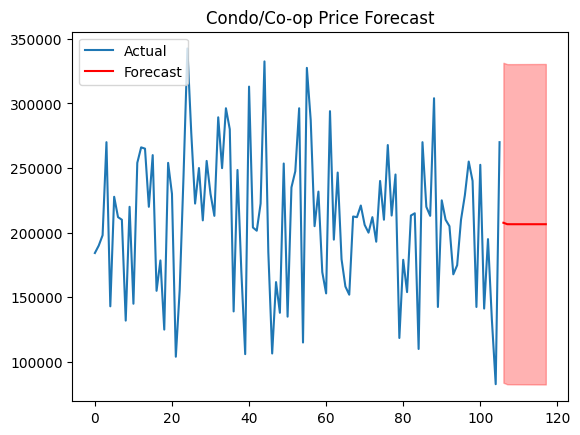

In [32]:
plt.plot(condo_coop[target],label="Actual")
plt.plot(range(len(condo_coop), len(condo_coop) + 12),
         condo_coop_forecast_df["mean"], label="Forecast", color="red"
)
plt.fill_between(range(len(condo_coop), len(condo_coop) + 12),
                 condo_coop_forecast_df["mean_ci_lower"], condo_coop_forecast_df["mean_ci_upper"],
                 alpha=0.3, color="red")

plt.legend()
plt.title("Condo/Co-op Price Forecast")
plt.show()

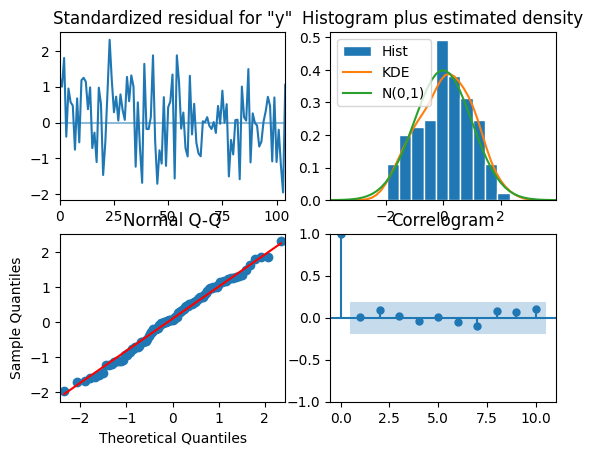

In [ ]:
plt.figure(figsize=(15, 7))
condo_coop_fit.plot_diagnostics()
plt.show()

In [31]:
chart1 = alt.Chart(condo_coop_forecast_df).encode(
    x=alt.X(range(len(condo_coop), len(condo_coop) + 12)),
    y=alt.Y("mean:Q")
)
chart1

SchemaValidationError: '[106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117]' is an invalid value for `field`. Valid values are of type `str | Mapping[str, Any]`.

alt.Chart(...)